# NBA Team Performance Analysis (1946–2022)
### A SQL-First Analytics Project

This notebook presents a structured analysis of NBA team performance across historical eras using advanced SQL executed on a PostgreSQL database.

The objective of this project is to move beyond basic win–loss records and analyze:

- How team performance evolves over time
- Which teams show sustained dominance versus volatility
- Whether success is driven by offense, defense, or structural advantages
- How dominance compares relative to league context, not just raw totals

All analysis is performed using:
- Common Table Expressions (CTEs)
- Window functions
- Time-series analysis
- Ranking and normalization techniques

Python is used only as a presentation layer.  
The core logic and insights are entirely SQL-driven.

In [2]:
# Database connection (PostgreSQL)
# This project is SQL-first. Python is only used to run and display queries.

import os
import psycopg2
import pandas as pd

# Connection parameters
DB_NAME = "nba_sql_portfolio"
DB_USER = "postgres"
DB_PASSWORD = "ganesh"
DB_HOST = "localhost"
DB_PORT = "5432"

conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)


Note:  
This notebook assumes a local PostgreSQL database populated using the SQL scripts in the `/sql` folder.  
The analysis below focuses on query logic and interpretation, not database setup.


## Query 1 — Team Season Performance and Trends

This query builds the foundation for the entire analysis.

It answers:
- How did each team perform in each season?
- How did performance change year over year?
- What does short-term momentum look like across seasons?

The output includes:
- Win percentage by season
- Year-over-year change in win percentage
- A 3-season rolling average to smooth volatility


In [4]:
query_1 = """
WITH team_season AS (
  SELECT
    ftg.team_id,
    dt.team_full_name,
    ftg.season_id,
    ds.season_year,
    COUNT(*) AS games_played,
    SUM(ftg.is_win)::int AS wins,
    COUNT(*) - SUM(ftg.is_win)::int AS losses,
    ROUND((SUM(ftg.is_win)::numeric / COUNT(*)) * 100, 2) AS win_pct
  FROM analytics.fact_team_game ftg
  JOIN analytics.dim_team dt
    ON dt.team_id = ftg.team_id
  LEFT JOIN analytics.dim_season ds
    ON ds.season_id = ftg.season_id
  WHERE ftg.is_win IS NOT NULL
    AND ds.season_year IS NOT NULL
  GROUP BY 1,2,3,4
),
trend AS (
  SELECT
    *,
    ROUND(
      win_pct - LAG(win_pct) OVER (
        PARTITION BY team_id
        ORDER BY season_id
      ),
      2
    ) AS yoy_win_pct_change,
    ROUND(
      AVG(win_pct) OVER (
        PARTITION BY team_id
        ORDER BY season_id
        ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
      ),
      2
    ) AS rolling_3_season_win_pct
  FROM team_season
)
SELECT *
FROM trend
ORDER BY team_full_name, season_id

"""

df_q1 = pd.read_sql(query_1, conn)
df_q1


C:\Users\rgane\AppData\Local\Temp\ipykernel_34676\2813094791.py:47: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_q1 = pd.read_sql(query_1, conn)


,team_id,team_full_name,season_id,season_year,games_played,wins,losses,win_pct,yoy_win_pct_change,rolling_3_season_win_pct
0,1610612737,Atlanta Hawks,21949,1949,64,29,35,45.31,NaN,45.31
1,1610612737,Atlanta Hawks,21950,1950,68,25,43,36.76,-8.55,41.04
2,1610612737,Atlanta Hawks,21951,1951,66,17,49,25.76,-11.00,35.94
3,1610612737,Atlanta Hawks,21952,1952,71,27,44,38.03,12.27,33.52
4,1610612737,Atlanta Hawks,21953,1953,71,20,51,28.17,-9.86,30.65
...,...,...,...,...,...,...,...,...,...,...
1478,1610612764,Washington Wizards,22018,2018,82,32,50,39.02,-13.42,50.41
1479,1610612764,Washington Wizards,22019,2019,72,25,47,34.72,-4.30,42.06
1480,1610612764,Washington Wizards,22020,2020,72,34,38,47.22,12.50,40.32
1481,1610612764,Washington Wizards,22021,2021,82,35,47,42.68,-4.54,41.54


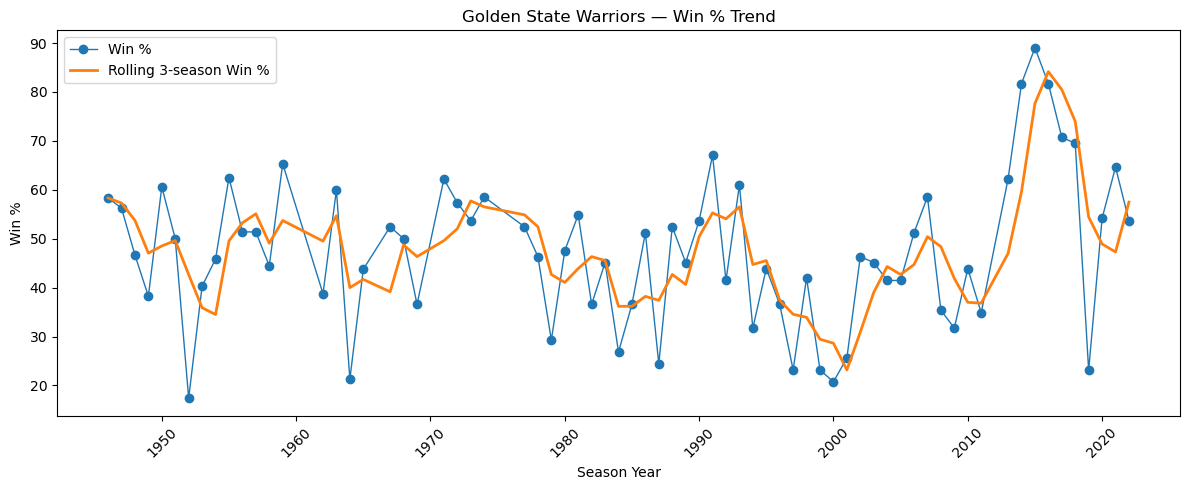

In [16]:
import matplotlib.pyplot as plt

def plot_team_win_trend(df, team_name):
    d = df[df["team_full_name"] == team_name].copy()
    d = d.sort_values("season_id")
    d = d.dropna(subset=["season_year", "win_pct"])
    
    plt.figure(figsize=(12, 5))
    plt.plot(d["season_year"], d["win_pct"], marker="o", linewidth=1, label="Win %")
    plt.plot(d["season_year"], d["rolling_3_season_win_pct"], linewidth=2, label="Rolling 3-season Win %")
    plt.title(f"{team_name} — Win % Trend")
    plt.xlabel("Season Year")
    plt.ylabel("Win %")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_team_win_trend(df_q1, "Golden State Warriors")


What to notice

- Each row represents one team in one season
- Year-over-year change highlights improvement or decline
- Rolling win percentage smooths out short-term noise
- Later queries build directly on these trends


## Query 2 — Home vs Away Performance

This query compares team performance at home versus away for each season.

It helps answer:
- Do teams perform significantly better at home?
- How large is the home-court advantage?
- Does this gap vary by team or season?

In [6]:
query_2 = """
WITH split AS (
  SELECT
    ftg.team_id,
    dt.team_full_name,
    ftg.season_id,
    ds.season_year,
    ftg.home_away,
    COUNT(*) AS games_played,
    SUM(ftg.is_win)::int AS wins,
    ROUND((SUM(ftg.is_win)::numeric / COUNT(*)) * 100, 2) AS win_pct
  FROM analytics.fact_team_game ftg
  JOIN analytics.dim_team dt
    ON dt.team_id = ftg.team_id
  LEFT JOIN analytics.dim_season ds
    ON ds.season_id = ftg.season_id
  WHERE ftg.is_win IS NOT NULL
    AND ds.season_year IS NOT NULL
  GROUP BY 1,2,3,4,5
),
pivoted AS (
  SELECT
    team_id,
    team_full_name,
    season_id,
    season_year,
    MAX(CASE WHEN home_away = 'H' THEN games_played END) AS home_games,
    MAX(CASE WHEN home_away = 'H' THEN wins END)        AS home_wins,
    MAX(CASE WHEN home_away = 'H' THEN win_pct END)     AS home_win_pct,
    MAX(CASE WHEN home_away = 'A' THEN games_played END) AS away_games,
    MAX(CASE WHEN home_away = 'A' THEN wins END)        AS away_wins,
    MAX(CASE WHEN home_away = 'A' THEN win_pct END)     AS away_win_pct
  FROM split
  GROUP BY 1,2,3,4
)
SELECT
  *,
  ROUND(home_win_pct - away_win_pct, 2) AS home_minus_away_win_pct
FROM pivoted
ORDER BY team_full_name, season_id

"""

df_q2 = pd.read_sql(query_2, conn)
df_q2


C:\Users\rgane\AppData\Local\Temp\ipykernel_34676\1954114984.py:44: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_q2 = pd.read_sql(query_2, conn)


,team_id,team_full_name,season_id,season_year,home_games,home_wins,home_win_pct,away_games,away_wins,away_win_pct,home_minus_away_win_pct
0,1610612737,Atlanta Hawks,21949,1949,36,23,63.89,28,6,21.43,42.46
1,1610612737,Atlanta Hawks,21950,1950,36,23,63.89,32,2,6.25,57.64
2,1610612737,Atlanta Hawks,21951,1951,27,14,51.85,39,3,7.69,44.16
3,1610612737,Atlanta Hawks,21952,1952,32,23,71.88,39,4,10.26,61.62
4,1610612737,Atlanta Hawks,21953,1953,29,15,51.72,42,5,11.90,39.82
...,...,...,...,...,...,...,...,...,...,...,...
1478,1610612764,Washington Wizards,22018,2018,41,22,53.66,41,10,24.39,29.27
1479,1610612764,Washington Wizards,22019,2019,36,16,44.44,36,9,25.00,19.44
1480,1610612764,Washington Wizards,22020,2020,36,19,52.78,36,15,41.67,11.11
1481,1610612764,Washington Wizards,22021,2021,41,21,51.22,41,14,34.15,17.07


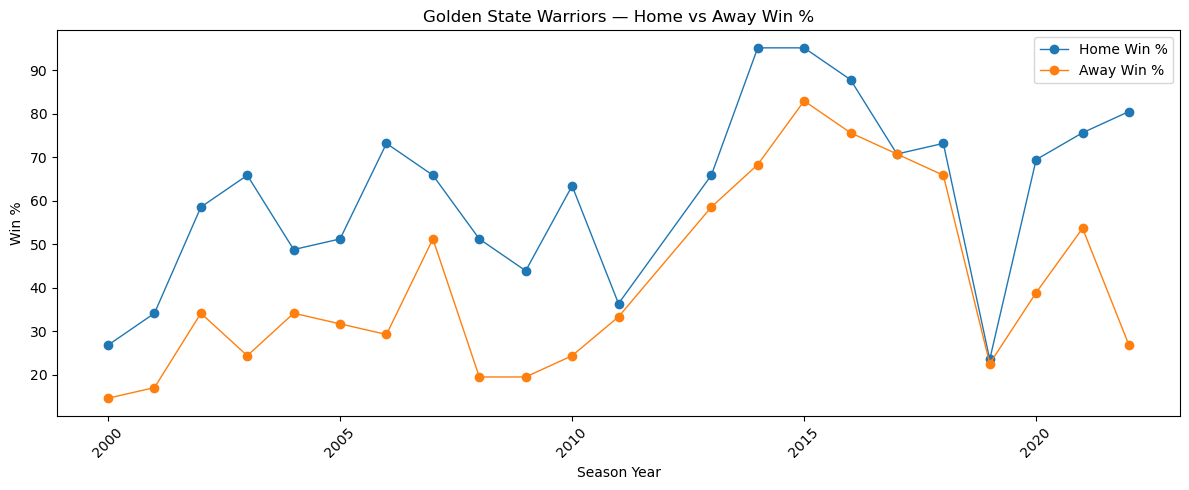

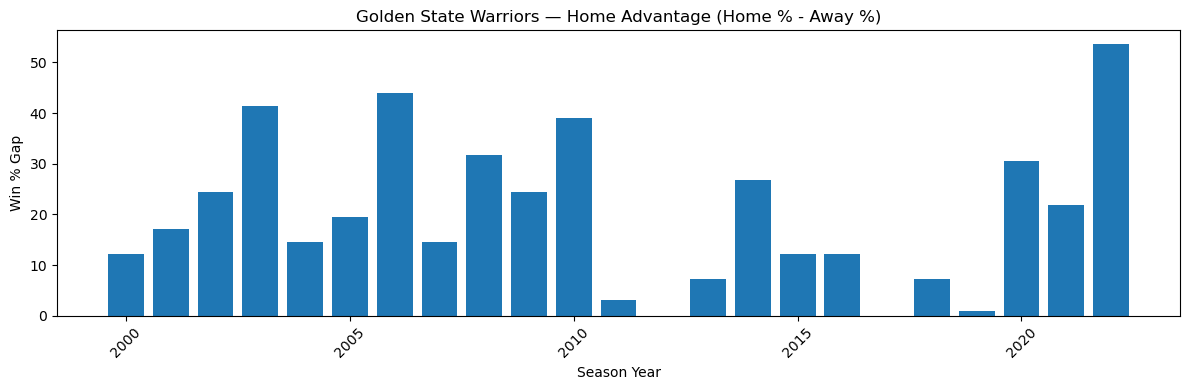

In [17]:
import matplotlib.pyplot as plt

def plot_home_away_gap(df, team_name, start_year=None, end_year=None):
    d = df[df["team_full_name"] == team_name].copy()
    d = d.dropna(subset=["season_year", "home_win_pct", "away_win_pct", "home_minus_away_win_pct"])
    d = d.sort_values("season_year")

    if start_year is not None:
        d = d[d["season_year"] >= start_year]
    if end_year is not None:
        d = d[d["season_year"] <= end_year]

    x = d["season_year"].astype(int)

    plt.figure(figsize=(12, 5))
    plt.plot(x, d["home_win_pct"], marker="o", linewidth=1, label="Home Win %")
    plt.plot(x, d["away_win_pct"], marker="o", linewidth=1, label="Away Win %")
    plt.title(f"{team_name} — Home vs Away Win %")
    plt.xlabel("Season Year")
    plt.ylabel("Win %")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.bar(x, d["home_minus_away_win_pct"])
    plt.title(f"{team_name} — Home Advantage (Home % - Away %)")
    plt.xlabel("Season Year")
    plt.ylabel("Win % Gap")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_home_away_gap(df_q2, "Golden State Warriors", start_year=2000)


What to notice

- Home win percentage is usually higher than away
- The home-minus-away gap varies by team and season
- Later queries examine whether dominance persists beyond home advantage


## Query 3 — Era-Wise Performance Volatility

This query identifies the largest year-over-year improvements and declines in team performance,
grouped by decade.

It helps answer:
- Which teams made the biggest leaps forward in each era?
- Which teams experienced the sharpest collapses?
- How performance volatility differs across decades

In [7]:
query_3 = """
WITH team_season AS (
  SELECT
    ftg.team_id,
    dt.team_full_name,
    ftg.season_id,
    ds.season_year,
    COUNT(*) AS games_played,
    ROUND((SUM(ftg.is_win)::numeric / COUNT(*)) * 100, 2) AS win_pct
  FROM analytics.fact_team_game ftg
  JOIN analytics.dim_team dt
    ON dt.team_id = ftg.team_id
  LEFT JOIN analytics.dim_season ds
    ON ds.season_id = ftg.season_id
  WHERE ftg.is_win IS NOT NULL
    AND ds.season_year IS NOT NULL
  GROUP BY 1,2,3,4
),
yoy AS (
  SELECT
    *,
    ROUND(
      win_pct - LAG(win_pct) OVER (
        PARTITION BY team_id
        ORDER BY season_id
      ),
      2
    ) AS yoy_win_pct_change
  FROM team_season
),
filtered AS (
  SELECT *
  FROM yoy
  WHERE yoy_win_pct_change IS NOT NULL
    AND games_played >= 60
),
decades AS (
  SELECT
    *,
    (season_year / 10) * 10 AS decade
  FROM filtered
),
ranked AS (
  SELECT
    decade,
    team_full_name,
    season_year,
    games_played,
    win_pct,
    yoy_win_pct_change,
    DENSE_RANK() OVER (PARTITION BY decade ORDER BY yoy_win_pct_change DESC) AS improve_rnk,
    DENSE_RANK() OVER (PARTITION BY decade ORDER BY yoy_win_pct_change ASC)  AS decline_rnk
  FROM decades
)
SELECT
  decade,
  'TOP_IMPROVEMENTS' AS bucket,
  team_full_name,
  season_year,
  games_played,
  win_pct,
  yoy_win_pct_change,
  improve_rnk AS rnk
FROM ranked
WHERE improve_rnk <= 3

UNION ALL

SELECT
  decade,
  'TOP_DECLINES' AS bucket,
  team_full_name,
  season_year,
  games_played,
  win_pct,
  yoy_win_pct_change,
  decline_rnk AS rnk
FROM ranked
WHERE decline_rnk <= 3

ORDER BY decade, bucket, rnk;
"""

df_q3 = pd.read_sql(query_3, conn)
df_q3


C:\Users\rgane\AppData\Local\Temp\ipykernel_34676\1531237225.py:84: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_q3 = pd.read_sql(query_3, conn)


,decade,bucket,team_full_name,season_year,games_played,win_pct,yoy_win_pct_change,rnk
0,1940,TOP_DECLINES,Golden State Warriors,1948,60,46.67,-9.58,1
1,1940,TOP_DECLINES,Boston Celtics,1949,68,32.35,-9.32,2
2,1940,TOP_DECLINES,Golden State Warriors,1949,68,38.24,-8.43,3
3,1940,TOP_IMPROVEMENTS,Detroit Pistons,1949,69,59.42,22.75,1
4,1940,TOP_IMPROVEMENTS,New York Knicks,1949,68,58.82,5.49,2
5,1940,TOP_IMPROVEMENTS,Los Angeles Lakers,1949,69,75.36,2.03,3
6,1950,TOP_DECLINES,Golden State Warriors,1952,69,17.39,-32.61,1
7,1950,TOP_DECLINES,Philadelphia 76ers,1950,66,48.48,-31.21,2
8,1950,TOP_DECLINES,Sacramento Kings,1954,72,40.28,-20.83,3
9,1950,TOP_IMPROVEMENTS,Boston Celtics,1950,69,56.52,24.17,1


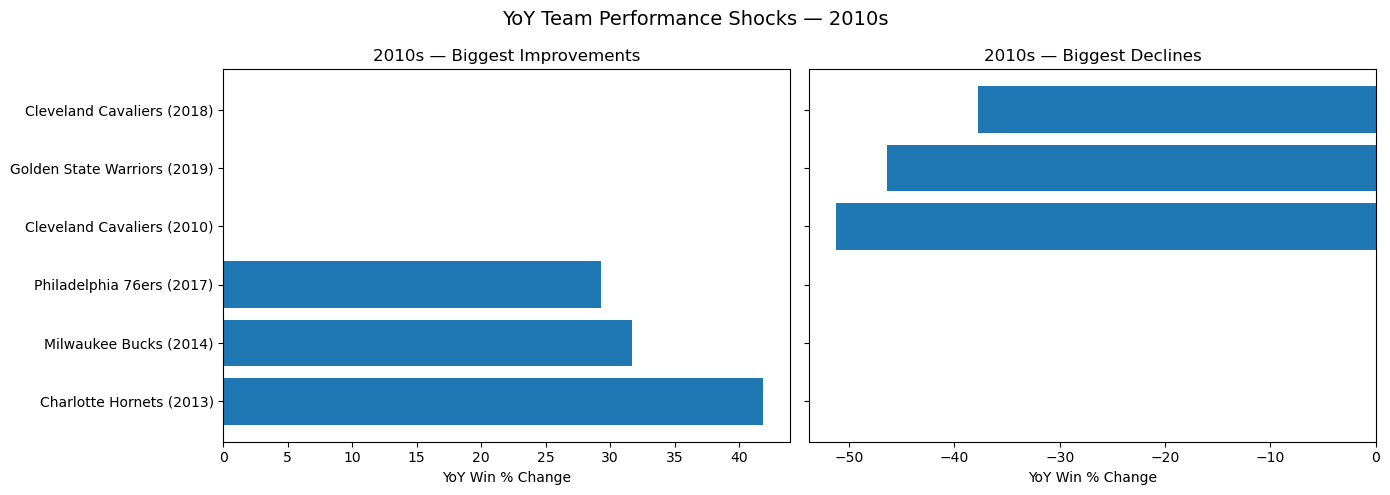

In [19]:
import matplotlib.pyplot as plt

def plot_yoy_shocks_by_decade(df, decade):
    d = df[df["decade"] == decade].copy()

    improve = d[d["bucket"] == "TOP_IMPROVEMENTS"].sort_values("rnk")
    decline = d[d["bucket"] == "TOP_DECLINES"].sort_values("rnk")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    axes[0].barh(
        improve["team_full_name"] + " (" + improve["season_year"].astype(str) + ")",
        improve["yoy_win_pct_change"]
    )
    axes[0].set_title(f"{decade}s — Biggest Improvements")
    axes[0].set_xlabel("YoY Win % Change")

    axes[1].barh(
        decline["team_full_name"] + " (" + decline["season_year"].astype(str) + ")",
        decline["yoy_win_pct_change"]
    )
    axes[1].set_title(f"{decade}s — Biggest Declines")
    axes[1].set_xlabel("YoY Win % Change")

    plt.suptitle(f"YoY Team Performance Shocks — {decade}s", fontsize=14)
    plt.tight_layout()
    plt.show()
    
plot_yoy_shocks_by_decade(df_q3, 2010)


What to notice

- Volatility exists in every era, but magnitude varies
- Some decades show larger swings than others
- Later queries examine whether strong improvements lead to sustained success


## Query 4 — Sustained Dominance Over Time

This query measures long-term excellence by calculating a rolling 5-season
win percentage for each team.

It highlights teams that:
- Win consistently across multiple seasons
- Avoid large performance swings
- Represent true sustained dominance rather than one-off peaks


In [10]:
query_4 = """
WITH team_season AS (
  SELECT
    ftg.team_id,
    dt.team_full_name,
    ftg.season_id,
    ds.season_year,
    COUNT(*) AS games_played,
    ROUND((SUM(ftg.is_win)::numeric / COUNT(*)) * 100, 2) AS win_pct
  FROM analytics.fact_team_game ftg
  JOIN analytics.dim_team dt
    ON dt.team_id = ftg.team_id
  LEFT JOIN analytics.dim_season ds
    ON ds.season_id = ftg.season_id
  WHERE ftg.is_win IS NOT NULL
    AND ds.season_year IS NOT NULL
  GROUP BY 1,2,3,4
),
rolling AS (
  SELECT
    *,
    ROUND(
      AVG(win_pct) OVER (
        PARTITION BY team_id
        ORDER BY season_id
        ROWS BETWEEN 4 PRECEDING AND CURRENT ROW
      ),
      2
    ) AS rolling_5_season_win_pct,
    ROUND(
      STDDEV_SAMP(win_pct) OVER (
        PARTITION BY team_id
        ORDER BY season_id
        ROWS BETWEEN 4 PRECEDING AND CURRENT ROW
      ),
      2
    ) AS rolling_5_season_win_pct_stddev
  FROM team_season
),
filtered AS (
  SELECT *
  FROM rolling
  WHERE games_played >= 60
    AND rolling_5_season_win_pct IS NOT NULL
)
SELECT
  team_full_name,
  season_year,
  season_id,
  win_pct,
  rolling_5_season_win_pct,
  rolling_5_season_win_pct_stddev,
  RANK() OVER (ORDER BY rolling_5_season_win_pct DESC) AS rnk
FROM filtered
ORDER BY rolling_5_season_win_pct DESC
LIMIT 15;
"""

df_q4 = pd.read_sql(query_4, conn)
df_q4


C:\Users\rgane\AppData\Local\Temp\ipykernel_34676\410090034.py:59: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_q4 = pd.read_sql(query_4, conn)


,team_full_name,season_year,season_id,win_pct,rolling_5_season_win_pct,rolling_5_season_win_pct_stddev,rnk
0,Philadelphia 76ers,1949,21949,79.69,79.69,NaN,1
1,Golden State Warriors,2018,22018,69.51,78.54,8.25,2
2,Golden State Warriors,2017,22017,70.73,77.07,10.57,3
3,Boston Celtics,1985,21985,81.71,75.85,4.83,4
4,Los Angeles Lakers,1989,21989,76.83,75.37,3.60,5
5,Los Angeles Lakers,1988,21988,69.51,75.12,3.51,6
6,Boston Celtics,1987,21987,69.51,75.12,4.69,6
7,Sacramento Kings,1948,21948,75.00,75.00,NaN,8
8,Boston Celtics,1964,21964,77.50,74.93,2.97,9
9,San Antonio Spurs,2016,22016,74.39,74.91,5.22,10


What this shows

- These teams were not just good — they were good repeatedly
- Lower standard deviation indicates stability
- Rolling windows prevent overreacting to single-season outliers


## Query 5 — Are Wins Backed by Real Dominance?

This query evaluates whether successful teams actually dominate games
by analyzing average point differential.

A rolling 3-season average is used to reduce single-season noise and
identify teams with sustained on-court superiority.


In [11]:
query_5 = """
WITH team_season_margin AS (
  SELECT
    ftg.team_id,
    dt.team_full_name,
    ftg.season_id,
    ds.season_year,
    COUNT(*) AS games_played,
    ROUND(AVG(ftg.point_diff), 2) AS avg_point_diff
  FROM analytics.fact_team_game ftg
  JOIN analytics.dim_team dt
    ON dt.team_id = ftg.team_id
  LEFT JOIN analytics.dim_season ds
    ON ds.season_id = ftg.season_id
  WHERE ftg.point_diff IS NOT NULL
    AND ds.season_year IS NOT NULL
  GROUP BY 1,2,3,4
),
rolling AS (
  SELECT
    *,
    ROUND(
      AVG(avg_point_diff) OVER (
        PARTITION BY team_id
        ORDER BY season_id
        ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
      ),
      2
    ) AS rolling_3yr_avg_point_diff
  FROM team_season_margin
),
filtered AS (
  SELECT *
  FROM rolling
  WHERE games_played >= 60
    AND rolling_3yr_avg_point_diff IS NOT NULL
)
SELECT
  team_full_name,
  season_year,
  avg_point_diff,
  rolling_3yr_avg_point_diff,
  RANK() OVER (ORDER BY rolling_3yr_avg_point_diff DESC) AS rnk
FROM filtered
ORDER BY rolling_3yr_avg_point_diff DESC
LIMIT 15;
"""

df_q5 = pd.read_sql(query_5, conn)
df_q5


C:\Users\rgane\AppData\Local\Temp\ipykernel_34676\801803691.py:49: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_q5 = pd.read_sql(query_5, conn)


,team_full_name,season_year,avg_point_diff,rolling_3yr_avg_point_diff,rnk
0,Golden State Warriors,2016,11.63,10.83,1
1,Chicago Bulls,1997,7.11,10.05,2
2,Golden State Warriors,2017,5.98,9.46,3
3,Chicago Bulls,1996,10.80,9.29,4
4,Milwaukee Bucks,1973,8.04,9.14,5
5,Chicago Bulls,1992,6.29,8.61,6
6,Golden State Warriors,2015,10.76,8.55,7
7,Oklahoma City Thunder,1995,7.79,8.35,8
8,Milwaukee Bucks,2020,5.89,8.28,9
9,San Antonio Spurs,2015,10.63,8.18,10


What this shows

- Teams with high rolling point differential tend to be true contenders
- Rolling averages reduce fluke seasons
- Confirms whether wins are supported by actual dominance


## Query 6 — Offense vs Defense Driven Teams

This query analyzes whether successful teams win primarily through
offensive firepower or defensive strength.

We compare:
- Average points scored
- Average points conceded
- Net point differential

Teams are ranked by defensive efficiency (lower points allowed).


In [12]:
query_6 = """
WITH team_season_scoring AS (
  SELECT
    ftg.team_id,
    dt.team_full_name,
    ftg.season_id,
    ds.season_year,
    COUNT(*) AS games_played,
    ROUND(AVG(ftg.pts_for), 2)     AS avg_points_for,
    ROUND(AVG(ftg.pts_against), 2) AS avg_points_against
  FROM analytics.fact_team_game ftg
  JOIN analytics.dim_team dt
    ON dt.team_id = ftg.team_id
  LEFT JOIN analytics.dim_season ds
    ON ds.season_id = ftg.season_id
  WHERE ds.season_year IS NOT NULL
  GROUP BY 1,2,3,4
),
metrics AS (
  SELECT
    *,
    ROUND(avg_points_for - avg_points_against, 2) AS net_point_diff
  FROM team_season_scoring
),
filtered AS (
  SELECT *
  FROM metrics
  WHERE games_played >= 60
)
SELECT
  team_full_name,
  season_year,
  avg_points_for,
  avg_points_against,
  net_point_diff,
  RANK() OVER (ORDER BY avg_points_against ASC) AS defensive_rank
FROM filtered
ORDER BY defensive_rank
LIMIT 15;
"""

df_q6 = pd.read_sql(query_6, conn)
df_q6


C:\Users\rgane\AppData\Local\Temp\ipykernel_34676\4022155532.py:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_q6 = pd.read_sql(query_6, conn)


,team_full_name,season_year,avg_points_for,avg_points_against,net_point_diff,defensive_rank
0,New York Knicks,1946,64.72,64.03,0.69,1
1,Boston Celtics,1946,60.08,64.97,-4.89,2
2,Golden State Warriors,1946,68.63,65.15,3.48,3
3,Sacramento Kings,1949,82.29,74.67,7.62,4
4,Atlanta Hawks,1953,70.06,75.56,-5.50,5
5,Los Angeles Lakers,1949,83.99,75.74,8.25,6
6,Detroit Pistons,1953,77.68,76.06,1.62,7
7,Golden State Warriors,1949,73.28,76.38,-3.10,8
8,Los Angeles Lakers,1948,84.03,76.65,7.38,9
9,Philadelphia 76ers,1949,84.86,76.69,8.17,10


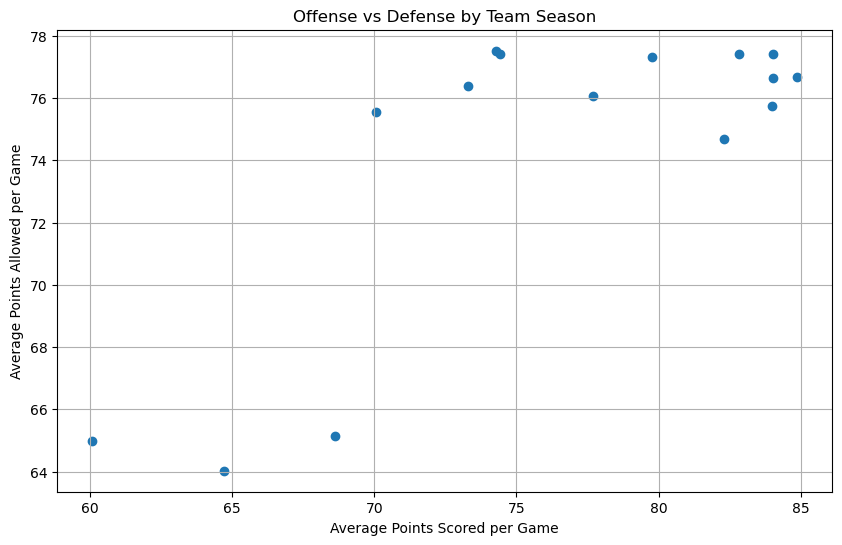

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(
    df_q6["avg_points_for"],
    df_q6["avg_points_against"]
)

plt.xlabel("Average Points Scored per Game")
plt.ylabel("Average Points Allowed per Game")
plt.title("Offense vs Defense by Team Season")

plt.grid(True)
plt.show()


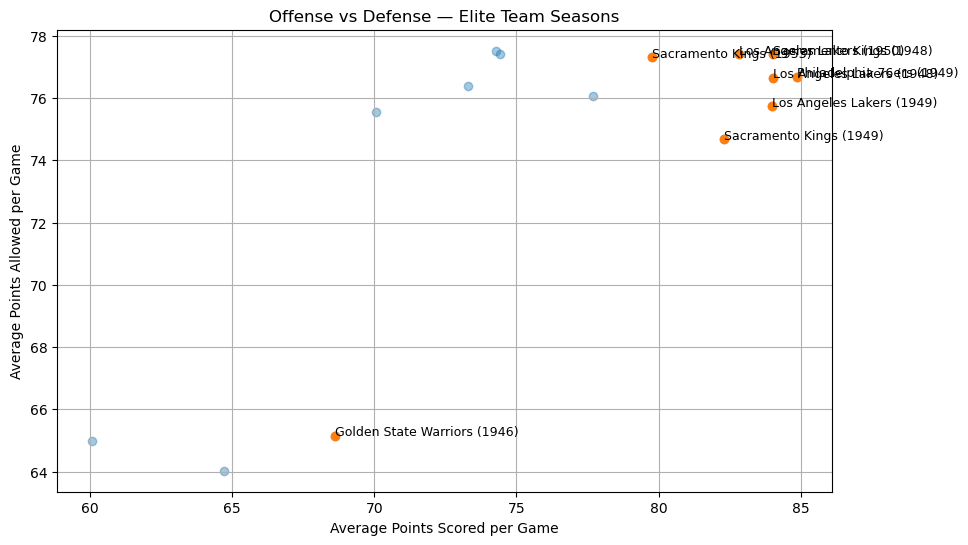

In [24]:
top = df_q6.sort_values("net_point_diff", ascending=False).head(8)

plt.figure(figsize=(10, 6))

plt.scatter(
    df_q6["avg_points_for"],
    df_q6["avg_points_against"],
    alpha=0.4
)

plt.scatter(
    top["avg_points_for"],
    top["avg_points_against"]
)

for _, r in top.iterrows():
    plt.text(
        r["avg_points_for"],
        r["avg_points_against"],
        f'{r["team_full_name"]} ({r["season_year"]})',
        fontsize=9
    )

plt.xlabel("Average Points Scored per Game")
plt.ylabel("Average Points Allowed per Game")
plt.title("Offense vs Defense — Elite Team Seasons")

plt.grid(True)
plt.show()


What this shows

- Lower average points against = stronger defense
- Net point differential explains overall dominance
- Some elite teams rank high without extreme scoring, proving defense-first success


## Query 7 — Era-Normalized Dominance

Raw stats are misleading across eras.

This query compares each team to the league average in the same season:
- Scoring vs league
- Defense vs league
- Point differential vs league

This allows fair comparison across NBA history.


In [13]:
query_7 = """
WITH team_season AS (
  SELECT
    ftg.team_id,
    dt.team_full_name,
    ftg.season_id,
    ds.season_year,
    COUNT(*) AS games_played,
    ROUND(AVG(ftg.pts_for), 2)      AS avg_pts_for,
    ROUND(AVG(ftg.pts_against), 2)  AS avg_pts_against,
    ROUND(AVG(ftg.point_diff), 2)   AS avg_point_diff,
    ROUND((SUM(ftg.is_win)::numeric / COUNT(*)) * 100, 2) AS win_pct
  FROM analytics.fact_team_game ftg
  JOIN analytics.dim_team dt
    ON dt.team_id = ftg.team_id
  LEFT JOIN analytics.dim_season ds
    ON ds.season_id = ftg.season_id
  WHERE ds.season_year IS NOT NULL
    AND ftg.is_win IS NOT NULL
  GROUP BY 1,2,3,4
),
league_baseline AS (
  SELECT
    season_id,
    season_year,
    ROUND(AVG(avg_pts_for), 2)     AS lg_avg_pts_for,
    ROUND(AVG(avg_pts_against), 2) AS lg_avg_pts_against,
    ROUND(AVG(avg_point_diff), 2)  AS lg_avg_point_diff
  FROM team_season
  WHERE games_played >= 60
  GROUP BY 1,2
),
normalized AS (
  SELECT
    ts.team_full_name,
    ts.season_year,
    ts.season_id,
    ts.games_played,
    ts.win_pct,
    ts.avg_point_diff,
    ROUND(ts.avg_point_diff - lb.lg_avg_point_diff, 2) AS point_diff_vs_lg,
    ROUND(ts.avg_pts_for - lb.lg_avg_pts_for, 2)       AS pts_for_vs_lg,
    ROUND(ts.avg_pts_against - lb.lg_avg_pts_against, 2) AS pts_against_vs_lg
  FROM team_season ts
  JOIN league_baseline lb
    ON lb.season_id = ts.season_id
  WHERE ts.games_played >= 60
)
SELECT
  team_full_name,
  season_year,
  win_pct,
  avg_point_diff,
  point_diff_vs_lg,
  pts_for_vs_lg,
  pts_against_vs_lg,
  RANK() OVER (ORDER BY point_diff_vs_lg DESC) AS rnk
FROM normalized
ORDER BY rnk
LIMIT 20;
"""

df_q7 = pd.read_sql(query_7, conn)
df_q7


C:\Users\rgane\AppData\Local\Temp\ipykernel_34676\3816591980.py:63: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_q7 = pd.read_sql(query_7, conn)


,team_full_name,season_year,win_pct,avg_point_diff,point_diff_vs_lg,pts_for_vs_lg,pts_against_vs_lg,rnk
0,Los Angeles Lakers,1971,84.15,12.28,12.28,10.79,-1.49,1
1,Chicago Bulls,1995,87.80,12.24,12.24,5.68,-6.56,2
2,Golden State Warriors,2016,81.71,11.63,11.63,10.30,-1.33,3
3,Milwaukee Bucks,1971,76.83,11.16,11.16,4.44,-6.71,4
4,Chicago Bulls,1996,84.15,10.80,10.80,6.25,-4.56,5
5,Golden State Warriors,2015,89.02,10.76,10.76,12.22,1.46,6
6,San Antonio Spurs,2015,81.71,10.63,10.63,0.87,-9.77,7
7,Chicago Bulls,1991,81.71,10.44,10.44,4.58,-5.86,8
8,Boston Celtics,2007,80.49,10.26,10.26,0.63,-9.63,9
9,Milwaukee Bucks,2019,76.71,10.08,10.24,6.98,-3.26,10


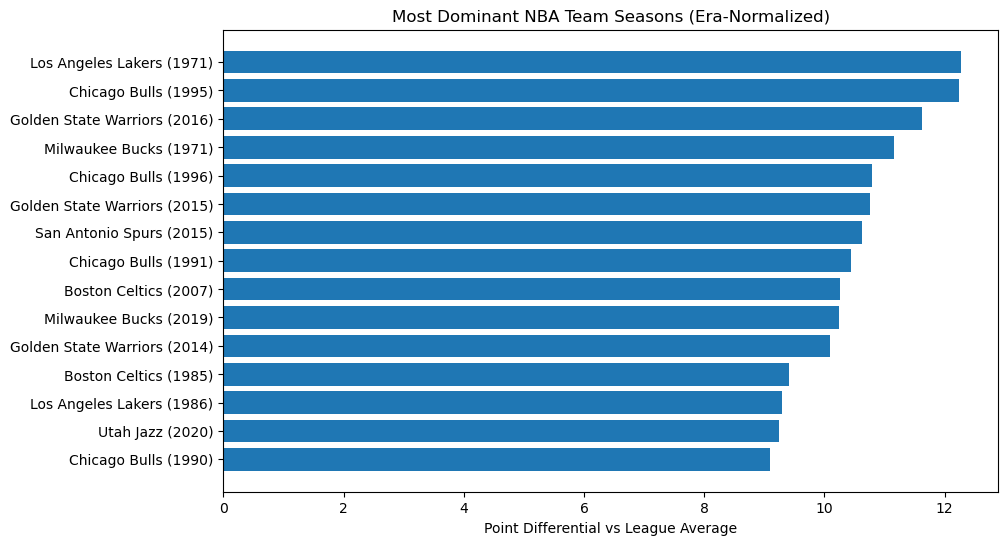

In [25]:
df_top = df_q7.sort_values("point_diff_vs_lg", ascending=False).head(15)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

labels = df_top["team_full_name"] + " (" + df_top["season_year"].astype(str) + ")"

plt.barh(
    labels,
    df_top["point_diff_vs_lg"]
)

plt.xlabel("Point Differential vs League Average")
plt.title("Most Dominant NBA Team Seasons (Era-Normalized)")
plt.gca().invert_yaxis()

plt.show()


What this shows

- Positive values mean the team outperformed its league peers
- This allows fair comparison across decades
- Dominance is measured relative to competition, not raw totals
